In [6]:
#import Required Libraries
import pandas as pd
import numpy as np  
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
import openpyxl as px
import matplotlib.pyplot as plt
import v1 as v1



In [7]:
#load the dataset

data = pd.read_csv("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/DATA/RADCURE_Clinical_v04_20241219.csv")


#encode and remove missing values from key columns
cleaned_data = v1.clean_data(data)

#save as a new excel file
cleaned_data.to_csv("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/DATA/RADCURE_Cleaned.csv", index=False)    

In [8]:
#Prepare the data for survival analysis

duration = cleaned_data["FollowUp_Length"]  # calculated time as decimal years
status = cleaned_data["Survival_Status"] #1 for alive, 2 for dead
print("first 15 rows of treatment type:", cleaned_data["Treatment_Type"].head(15))

#Setting the Groups for comparison for Kaplan-Meier analysis
set1 = cleaned_data[cleaned_data["Treatment_Type"] == 1]  #RT alone
set2 = cleaned_data[cleaned_data["Treatment_Type"] == 2] #chemotherapy alone
set3 = cleaned_data[cleaned_data["Treatment_Type"] == 3]  #RT + EGFRI
set4 = cleaned_data[cleaned_data["Treatment_Type"] == 4]  #Postop RT alone

 

#check if followup length and survival status are numeric . check if empty
# print("Is FollowUp_Length empty:", set1['FollowUp_Length'].isnull().sum())
# print("first 15 rows of FollowUp_Length:", set1['FollowUp_Length'].head(15))
# print("Is Survival_Status empty:", set1['Survival_Status'].isnull().sum())
# print("FollowUp_Length is numeric:", pd.api.types.is_numeric_dtype(set1['FollowUp_Length']))
# print("Survival_Status is numeric:", pd.api.types.is_numeric_dtype(set1['Survival_Status']))



first 15 rows of treatment type: 0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    2
13    1
14    2
Name: Treatment_Type, dtype: int64


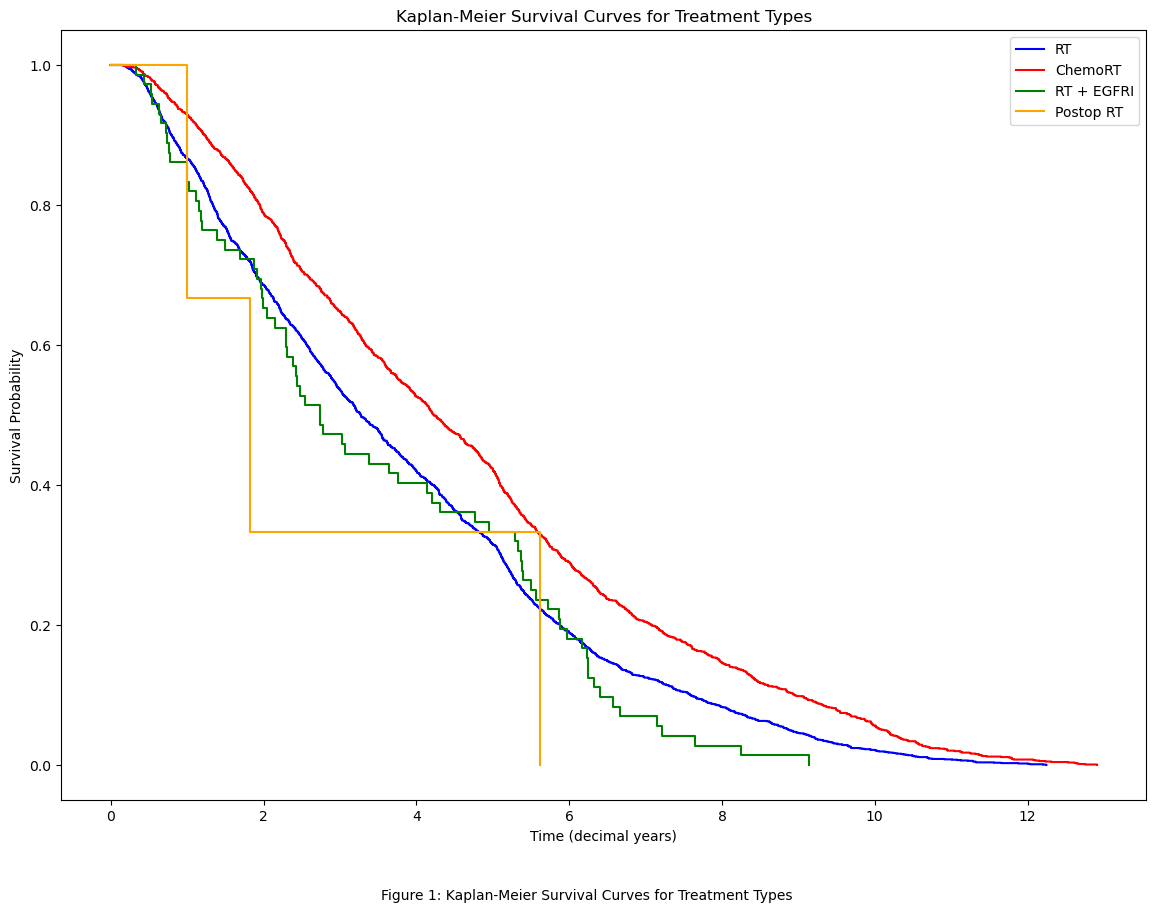

In [18]:
#Set up the Kaplan-Meier Fitter for treatment types

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()

#Fit the data for the first group (RT)
kmf1.fit(durations=set1["FollowUp_Length"], event_observed=set1["Survival_Status"], label='RT')
kmf2.fit(durations=set2["FollowUp_Length"], event_observed=set2["Survival_Status"], label='ChemoRT')
kmf3.fit(durations=set3["FollowUp_Length"], event_observed=set3["Survival_Status"], label='RT + EGFRI')
kmf4.fit(durations=set4["FollowUp_Length"], event_observed=set4["Survival_Status"], label='Postop RT')
#Plot the survival functions for each treatment type on the same 


#create a figure with 4 subplots for size 12 by 14
fig, ax = plt.subplots(figsize=(14, 10))    
#plot the survival functions on the same axes

kmf1.plot_survival_function(ax=ax, label='RT', color='blue', ci_show=False)
kmf2.plot_survival_function(ax=ax, label='ChemoRT', color='red', ci_show=False)
kmf3.plot_survival_function(ax=ax, label='RT + EGFRI', color='green', ci_show=False)
kmf4.plot_survival_function(ax=ax, label='Postop RT', color='orange', ci_show=False)
#add labels and title
ax.set_xlabel('Time (decimal years)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curves for Treatment Types')
ax.legend()

 


#addinf figure caption
plt.figtext(0.5, 0.01, "Figure 1: Kaplan-Meier Survival Curves for Treatment Types", ha='center', fontsize=10)
#show the plot
plt.show()

#save the plot as a png file
fig.savefig("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/FIGURES/KM_Tx.png", bbox_inches='tight')

In [ ]:
#Kaplan-Meier logrank test for comparison between treatment types

from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test

results = multivariate_logrank_test(
    duration, 
    status, 
    cleaned_data["Treatment_Type"])

# Print the results of the logrank test
print("Logrank test results:")  
print(results.summary)
print(f"Test statistic: {results.test_statistic:.4f}")
print(f"P-value: {results.p_value:.2e}")
print(f"Degrees of freedom: {results.degrees_of_freedom}")# Individual logrank tests for each treatment comparison
from lifelines.statistics import logrank_test

print("\n" + "="*80)
print("INDIVIDUAL LOGRANK TESTS FOR EACH TREATMENT COMPARISON")
print("="*80)

treatment_names = {1: 'RT alone', 2: 'ChemoRT', 3: 'RT + EGFRI', 4: 'Postop RT'}
comparisons = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4)]

for group1, group2 in comparisons:
    # Get data for each group
    data1 = cleaned_data[cleaned_data["Treatment_Type"] == group1]
    data2 = cleaned_data[cleaned_data["Treatment_Type"] == group2]
    
    # Perform logrank test
    result = logrank_test(
        data1["FollowUp_Length"], data2["FollowUp_Length"],
        data1["Survival_Status"], data2["Survival_Status"]
    )
    
    print(f"\n{treatment_names[group1]} vs {treatment_names[group2]}:")
    print(f"  Test statistic: {result.test_statistic:.4f}")
    print(f"  P-value: {result.p_value:.6f}")
    print(f"  Significant (p<0.05): {'Yes' if result.p_value < 0.05 else 'No'}")
    
    # Sample sizes and event counts
    events1 = (data1["Survival_Status"] == 2).sum()
    events2 = (data2["Survival_Status"] == 2).sum()
    print(f"  Sample sizes: {treatment_names[group1]} (n={len(data1)}), {treatment_names[group2]} (n={len(data2)})")
    print(f"  Events: {treatment_names[group1]} ({events1}), {treatment_names[group2]} ({events2})")







            

Logrank test results:
   test_statistic             p    -log2(p)
0      397.631335  1.805373e-88  291.477375
Test statistic: 397.6313
P-value: 1.81e-88
Degrees of freedom: 1

INDIVIDUAL LOGRANK TESTS FOR EACH TREATMENT COMPARISON

RT alone vs ChemoRT:
  Test statistic: 72.6323
  P-value: 0.000000
  Significant (p<0.05): Yes
  Sample sizes: RT alone (n=1858), ChemoRT (n=1413)
  Events: RT alone (703), ChemoRT (318)

RT alone vs RT + EGFRI:
  Test statistic: 1.4314
  P-value: 0.231544
  Significant (p<0.05): No
  Sample sizes: RT alone (n=1858), RT + EGFRI (n=72)
  Events: RT alone (703), RT + EGFRI (35)

RT alone vs Postop RT:
  Test statistic: 0.5327
  P-value: 0.465458
  Significant (p<0.05): No
  Sample sizes: RT alone (n=1858), Postop RT (n=3)
  Events: RT alone (703), Postop RT (2)

ChemoRT vs RT + EGFRI:
  Test statistic: 14.6700
  P-value: 0.000128
  Significant (p<0.05): Yes
  Sample sizes: ChemoRT (n=1413), RT + EGFRI (n=72)
  Events: ChemoRT (318), RT + EGFRI (35)

ChemoRT vs

Age group distribution:
Age_Group
<40        91
40-60    1323
60-80    1705
>80       227
Name: count, dtype: int64


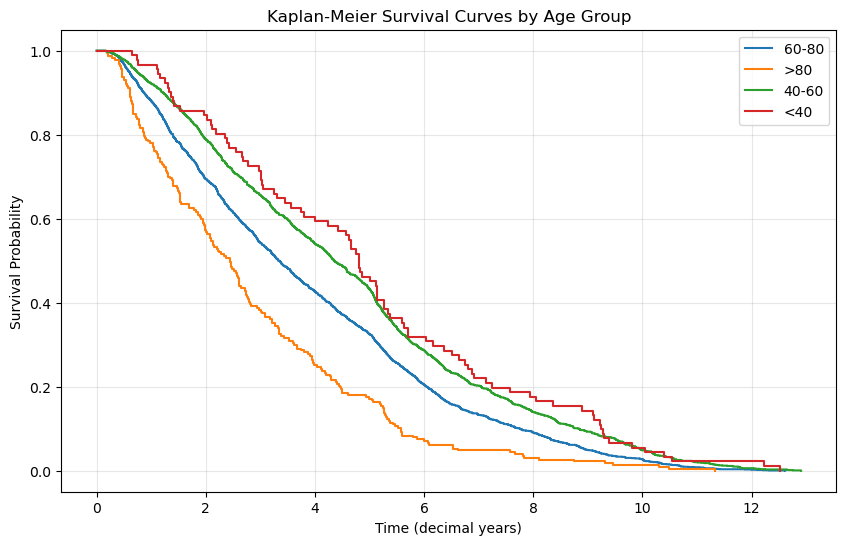


Logrank test results for Age Groups:
   test_statistic             p    -log2(p)
0      397.631335  1.805373e-88  291.477375
Test statistic: 397.6313
P-value: 1.81e-88
Degrees of freedom: 1

Pairwise logrank test results for Age Groups:
     test_statistic             p    -log2(p)
1 2      397.631335  1.805373e-88  291.477375


<Figure size 640x480 with 0 Axes>

In [ ]:
# Kaplan-Meier survival test for comparison between Age groups

# Create age groups using Patient_Age column
cleaned_data['Age_Group'] = pd.cut(cleaned_data['Patient_Age'], 
                                  bins=[0, 40, 60, 80, np.inf], 
                                  labels=['<40', '40-60', '60-80', '>80'])

print("Age group distribution:")
print(cleaned_data['Age_Group'].value_counts().sort_index())

# Plot Kaplan-Meier curves for age groups
kmf_age = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in cleaned_data["Age_Group"].dropna().unique():  
    mask = cleaned_data["Age_Group"] == group              
    kmf_age.fit(
        durations=cleaned_data["FollowUp_Length"][mask],   
        event_observed=cleaned_data["Survival_Status"][mask],  
        label=group
    )
    kmf_age.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Age Group")
plt.xlabel("Time (decimal years)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Calculate the logrank test for age groups
results_age = multivariate_logrank_test(
    cleaned_data["FollowUp_Length"], 
    cleaned_data["Survival_Status"], 
    cleaned_data["Age_Group"]
) 

# Print the results of the logrank test for age groups
print("\nLogrank test results for Age Groups:")
print(results_age.summary)
print(f"Test statistic: {results_age.test_statistic:.4f}")
print(f"P-value: {results_age.p_value:.2e}")
print(f"Degrees of freedom: {results_age.degrees_of_freedom}")

# Perform pairwise logrank tests for detailed comparison of age groups
print("\nPairwise logrank test results for Age Groups:")
pairwise_results_age = pairwise_logrank_test(
    cleaned_data["FollowUp_Length"], 
    cleaned_data["Survival_Status"], 
    cleaned_data["Age_Group"]
)
print(pairwise_results_age.summary)

#save figure
plt.savefig("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/FIGURES/KM_Age.png", bbox_inches='tight')


d:\VSCode ProjectsRepos\BINF-5007-Materials\.pixi\envs\default\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
d:\VSCode ProjectsRepos\BINF-5007-Materials\.pixi\envs\default\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
d:\VSCode ProjectsRepos\BINF-5007-Materials\.pixi\envs\default\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be c

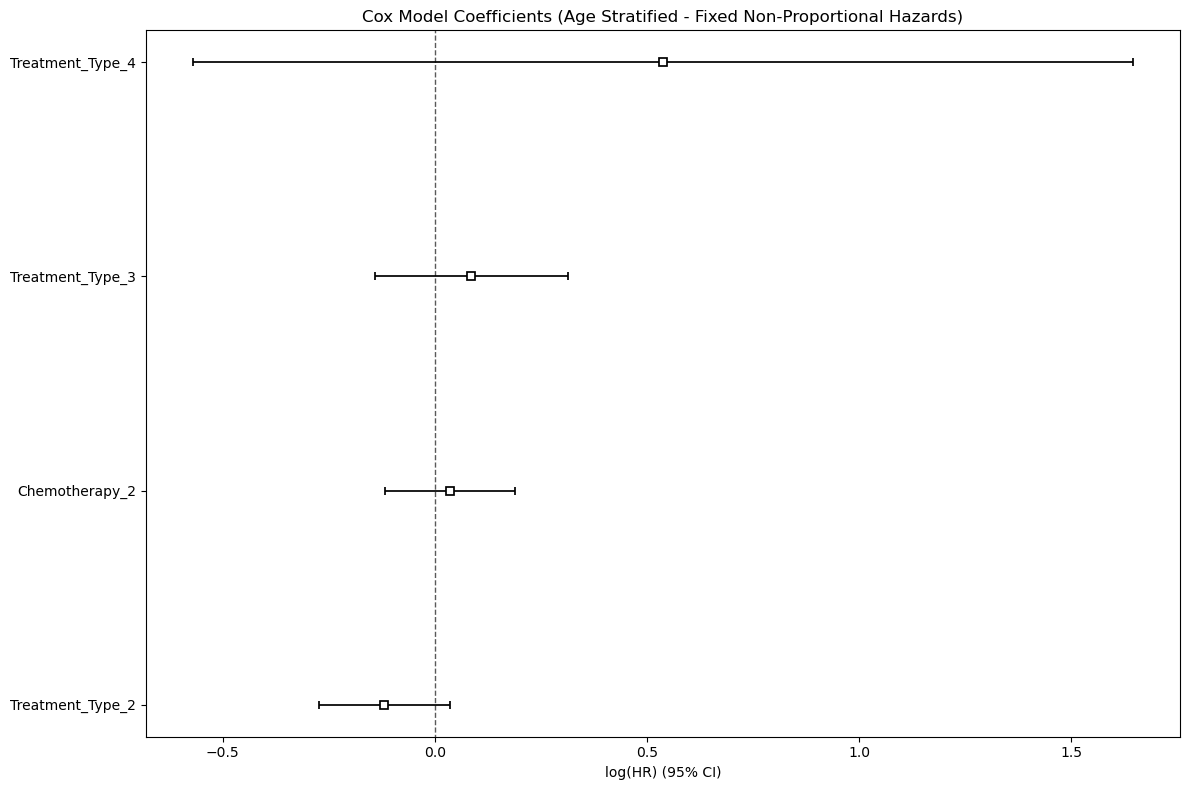

In [ ]:
# Cox Regression Analysis - Fixed for Non-Proportional Hazards (Age Stratification)
import v1 as v1

# Get the cox data subset
cox_data_stratified = v1.data_subset_cox(cleaned_data)

# Create age groups for stratification (binning as suggested)
cox_data_stratified['Age_Group'] = pd.cut(cox_data_stratified['Patient_Age'], 
                                         bins=[0, 50, 65, 80, np.inf], 
                                         labels=['<50', '50-65', '65-80', '>80'])


# Remove Patient_Age since we're stratifying by Age_Group instead
cox_data_stratified = cox_data_stratified.drop(['Patient_Age'], axis=1)

# Fit the Cox model with age stratification to handle non-proportional hazards
cph_stratified = CoxPHFitter(penalizer=0.1)

cph_stratified.fit(cox_data_stratified, 
                       duration_col='FollowUp_Length', 
                       event_col='Survival_Status',
                       strata=['Age_Group'])  # Stratify by age groups
    

# Plot the coefficients
plt.figure(figsize=(12, 8))
cph_stratified.plot()
plt.title("Cox Model Coefficients (Age Stratified - Fixed Non-Proportional Hazards)")
plt.tight_layout()
plt.show()

#save the figure
plt.savefig("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/FIGURES/Cox_Age_Strata.png", bbox_inches='tight')
    


    



In [ ]:
print("CHECK PROPORTIONAL HAZARDS ASSUMPTION (AFTER STRATIFICATION)")
print("="*80)
hazard_test_stratified = cph_stratified.check_assumptions(cox_data_stratified, 
                                                             p_value_threshold=0.05, 
                                                             show_plots=True)
    
print(f"\nModel Summary:")
print(f"Stratified model AIC: {cph_stratified.AIC_:.2f}")
print(f"Stratified model Log-likelihood: {cph_stratified.log_likelihood_:.2f}")

In [ ]:
##Random Survival Forest Analysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


rf_data, rf_data_subset = v1.data_subset_rf(data)


# Convert the survival status to a boolean array (True for death event, False for alive
rf_data['Status'] = rf_data['Status'].apply(lambda x: True if x == 2 else False)

# Get the features (X)
data_x = rf_data_subset.copy()

# Create the target variable (y) from the main rf_data
data_y = np.array([(event, time) for event, time in zip(rf_data['Status'], rf_data['Length FU'])], 
                  dtype=[('Status', bool), ('Length FU', float)])

# Identify categorical and numerical columns based on actual data types and content
categorical_columns = []
numerical_columns = []

for col in data_x.columns:
    if data_x[col].dtype == 'object' or data_x[col].nunique() <= 10:
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)


if categorical_columns:
    # Ecode categorical variables using OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    categorical_data = data_x[categorical_columns]
    encoded_categorical = encoder.fit_transform(categorical_data)
    
    # Get feature names for encoded categorical variables
    feature_names_cat = encoder.get_feature_names_out(categorical_columns)
    
    # Combine numerical and encoded categorical data
    if numerical_columns:
        numerical_data = data_x[numerical_columns].values
        data_x_encoded = np.concatenate([numerical_data, encoded_categorical], axis=1)
        all_feature_names = numerical_columns + list(feature_names_cat)
    else:
        data_x_encoded = encoded_categorical
        all_feature_names = list(feature_names_cat)
else:
    # Only numerical columns
    data_x_encoded = data_x[numerical_columns].values
    all_feature_names = numerical_columns








Target variable shape: (1713,)


RandomSurvivalForest(random_state=42)

In [14]:
# Fit Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(data_x_encoded, data_y)

print("Random Survival Forest fitted successfully!")

Random Survival Forest fitted successfully!


In [ ]:
# Calculate permutation importance
result = permutation_importance(rsf, data_x_encoded, data_y, n_repeats=5, random_state=42)

feature_importance = pd.DataFrame(
    {
        "importances_mean": result["importances_mean"],
        "importances_std": result["importances_std"],
    },
    index=all_feature_names,
).sort_values(by="importances_mean", ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))



Top 10 Most Important Features:
                    importances_mean  importances_std
Age                         0.147736         0.004394
Smoking Status_nan          0.101221         0.006258
Stage_IVB                   0.042498         0.002585
Chemo_2                     0.028286         0.003405
Stage_IVA                   0.026855         0.001391


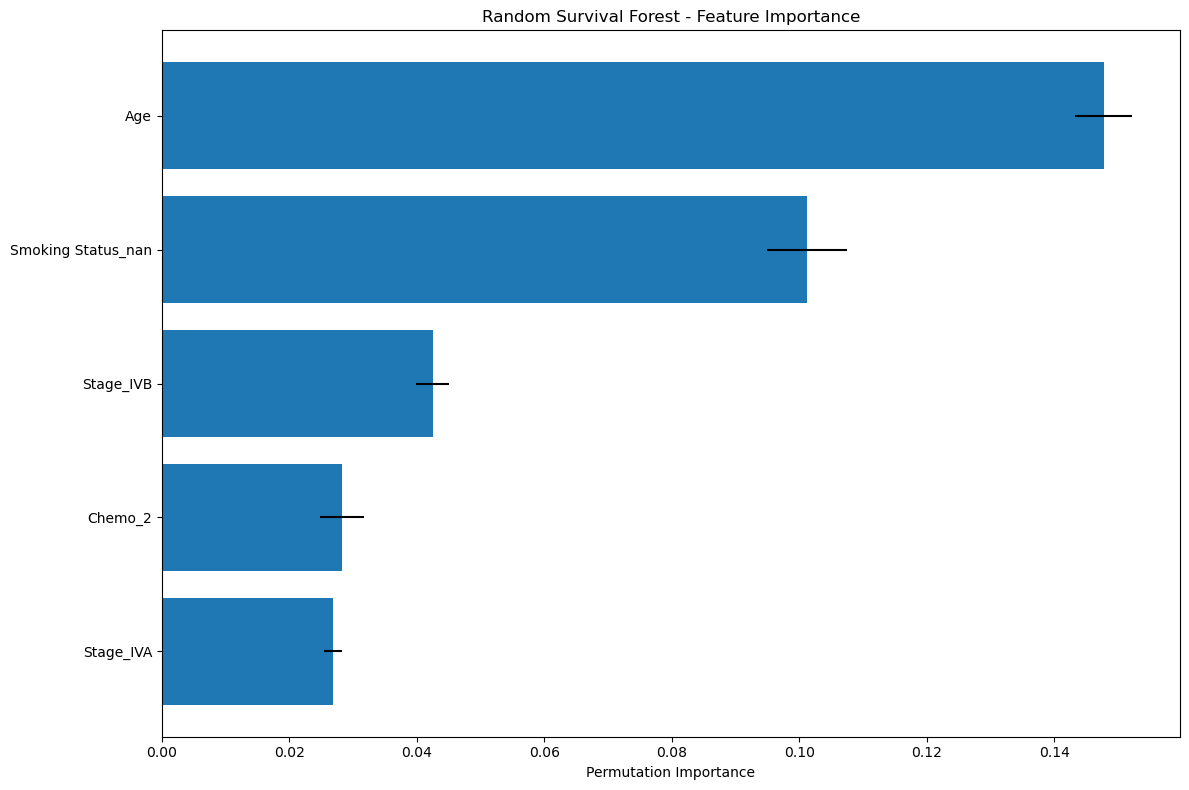

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(5)  # Show top 5 features

plt.barh(range(len(top_features)), top_features['importances_mean'], 
         xerr=top_features['importances_std'])
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Permutation Importance')
plt.title('Random Survival Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#save the figure
plt.savefig("d:/VSCode ProjectsRepos/BINF-5007-Materials/Assignment 4/FIGURES/RSF_Feature_Importance.png", bbox_inches='tight')